# 1. Import Packages and Read Data

In [1]:
#!pip install optuna

In [2]:
import lightgbm as lgbm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import optuna
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from numba import njit, prange
from itertools import combinations 

In [3]:
df_train = pd.read_csv('/kaggle/input/optiver-trading-at-the-close/train.csv')
df_test = pd.read_csv('/kaggle/input/optiver-trading-at-the-close/example_test_files/test.csv')
sample_sub = pd.read_csv('/kaggle/input/optiver-trading-at-the-close/example_test_files/sample_submission.csv')
rev_target = pd.read_csv('/kaggle/input/optiver-trading-at-the-close/example_test_files/revealed_targets.csv')

# 2. MEM Usage Optimization

In [4]:
def reduce_mem_usage(df, verbose=0):
    start_mem = df.memory_usage().sum() / 1024**2
    
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    timedelta_cols = df.select_dtypes(include=[np.timedelta64]).columns
    valid_cols = list(set(numeric_cols) - set(timedelta_cols))
    valid_cols = [col for col in valid_cols if col != 'stock_id']

    for col in valid_cols:        
        col_type = df[col].dtype
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()

            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:

                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float32)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float32)    
    
    return df

# 3. Feature Enginnering

In [5]:
# exclude feature columns
def feature_cols(df) :
    cols = [c for c in df.columns if c not in ['row_id', 'time_id', 'date_id',"currently_scored"]]
    df = df[cols]
    return df

In [6]:
# Parallel Triplet Imbalance Calculation
@njit(parallel=True)
def compute_triplet_imbalance(df_values, comb_indices):
    num_rows = df_values.shape[0]
    num_combinations = len(comb_indices)
    imbalance_features = np.empty((num_rows, num_combinations))
    for i in prange(num_combinations):
        a, b, c = comb_indices[i]
        for j in range(num_rows):
            max_val = max(df_values[j, a], df_values[j, b], df_values[j, c])
            min_val = min(df_values[j, a], df_values[j, b], df_values[j, c])
            mid_val = df_values[j, a] + df_values[j, b] + df_values[j, c] - min_val - max_val
            
            if mid_val == min_val:
                imbalance_features[j, i] = np.nan
            else:
                imbalance_features[j, i] = (max_val - mid_val) / (mid_val - min_val)

    return imbalance_features

def calculate_triplet_imbalance_numba(price, df):
    df_values = df[price].values
    comb_indices = [(price.index(a), price.index(b), price.index(c)) for a, b, c in combinations(price, 3)]
    features_array = compute_triplet_imbalance(df_values, comb_indices)
    columns = [f"{a}_{b}_{c}_imb2" for a, b, c in combinations(price, 3)]
    features = pd.DataFrame(features_array, columns=columns)
    return features

In [7]:
# Rolling Averages
@njit(fastmath=True)
def rolling_average(arr, window):
    """
    Calculate the rolling average for a 1D numpy array.
    
    Parameters:
    arr (numpy.ndarray): Input array to calculate the rolling average.
    window (int): The number of elements to consider for the moving average.
    
    Returns:
    numpy.ndarray: Array containing the rolling average values.
    """
    n = len(arr)
    result = np.empty(n)
    result[:window] = np.nan  # Padding with NaN for elements where the window is not full
    cumsum = np.cumsum(arr)

    for i in range(window, n):
        result[i] = (cumsum[i] - cumsum[i - window]) / window

    return result

@njit(parallel=True)
def compute_rolling_averages(df_values, window_sizes):
    """
    Calculate the rolling averages for multiple window sizes in parallel.
    
    Parameters:
    df_values (numpy.ndarray): 2D array of values to calculate the rolling averages.
    window_sizes (List[int]): List of window sizes for the rolling averages.
    
    Returns:
    numpy.ndarray: A 3D array containing the rolling averages for each window size.
    """
    num_rows, num_features = df_values.shape
    num_windows = len(window_sizes)
    rolling_features = np.empty((num_rows, num_features, num_windows))

    for feature_idx in prange(num_features):
        for window_idx, window in enumerate(window_sizes):
            rolling_features[:, feature_idx, window_idx] = rolling_average(df_values[:, feature_idx], window)

    return rolling_features

In [8]:
# adding new features to improve score
def pre_process1(df):

    # Define lists of price and size-related column names
    prices = ["reference_price", "far_price", "near_price", "ask_price", "bid_price", "wap"]
    sizes = ["matched_size", "bid_size", "ask_size", "imbalance_size"]
    
    # Basic Features
    df['imbalance_ratio'] = df['imbalance_size'] / df['matched_size']

    df['imbl_size1'] = (df['bid_size']-df['ask_size']) / (df['bid_size']+df['ask_size'])
    df['imbl_size2'] = (df['imbalance_size']-df['matched_size']) / (df['imbalance_size']+df['matched_size'])

    df["bid_size_over_ask_size"] = df["bid_size"].div(df["ask_size"])
    df["bid_price_over_ask_price"] = df["bid_price"].div(df["ask_price"])
    
    # A little increase in the MAE, so excluding this feature
    # df['Auction_Period'] = df['seconds_in_bucket'].apply(lambda x: 0 if x <= 300 else 1)
    
    # V1 features
    # Calculate various features using Pandas eval function
    df["volume"] = df.eval("ask_size + bid_size")
    df["mid_price"] = df.eval("ask_price + bid_price")/2
    df["liquidity_imbalance"] = df.eval("(bid_size-ask_size)/(bid_size+ask_size)")
    df["matched_imbalance"] = df.eval("imbalance_size-matched_size")/df.eval("matched_size+imbalance_size")
    df["size_imbalance"] = df.eval("bid_size / ask_size")
    
    # Create features for pairwise price imbalances
    for c in combinations(prices, 2):
        df[f"{c[0]}_{c[1]}_imb"] = df.eval(f"({c[0]} - {c[1]})/({c[0]} + {c[1]})")
            
    # Calculate triplet imbalance features using the Numba-optimized function
    for c in [['ask_price', 'bid_price', 'wap', 'reference_price'], sizes]:
        triplet_feature = calculate_triplet_imbalance_numba(c, df)
        df[triplet_feature.columns] = triplet_feature.values
        
    # V2 features
    # Calculate additional features
    df["imbalance_momentum"] = df.groupby(['stock_id'])['imbalance_size'].diff(periods=1) / df['matched_size']
    df["price_spread"] = df["ask_price"] - df["bid_price"]
    df["spread_intensity"] = df.groupby(['stock_id'])['price_spread'].diff()
    df['price_pressure'] = df['imbalance_size'] * (df['ask_price'] - df['bid_price'])
    df['market_urgency'] = df['price_spread'] * df['liquidity_imbalance']
    df['depth_pressure'] = (df['ask_size'] - df['bid_size']) * (df['far_price'] - df['near_price'])
    
    # Calculate various statistical aggregation features
    for func in ["mean", "std", "skew", "kurt"]:
        df[f"all_prices_{func}"] = df[prices].agg(func, axis=1)
        df[f"all_sizes_{func}"] = df[sizes].agg(func, axis=1)
        
    # V3 features
    # Calculate shifted and return features for specific columns
    for col in ['matched_size', 'imbalance_size', 'reference_price', 'imbalance_buy_sell_flag']:
        for window in [1, 2, 3, 10]:
            df[f"{col}_shift_{window}"] = df.groupby('stock_id')[col].shift(window)
            df[f"{col}_ret_{window}"] = df.groupby('stock_id')[col].pct_change(window)
    
    # V4 features - Rolling averages
    window_sizes = [1, 2, 3, 8, 10]  # Define your desired window sizes
    for price in prices:
        rolling_avg_features = compute_rolling_averages(df[price].values.reshape(-1, 1), window_sizes)

    # Assigning the rolling average results to the DataFrame
    for i, window in enumerate(window_sizes):
            column_name = f"{price}_rolling_avg_{window}"
            df[column_name] = rolling_avg_features[:, 0, i]
    
    # Calculate diff features for specific columns
    for col in ['ask_price', 'bid_price', 'ask_size', 'bid_size', 'market_urgency', 'imbalance_momentum', 'size_imbalance']:
        for window in [1, 2, 3, 10]:
            df[f"{col}_diff_{window}"] = df.groupby("stock_id")[col].diff(window)

    return df

# 4. Dataframe Manipulation

In [9]:
df_train = reduce_mem_usage(df_train)
df_test = reduce_mem_usage(df_test)

In [10]:
df_train = pre_process1(df_train)
df_train = feature_cols(df_train)
df_train.fillna(0, inplace = True)
df_train

/opt/conda/lib/python3.10/site-packages/numba/core/ir_utils.py:2149: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'comb_indices' of function 'compute_triplet_imbalance'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../../tmp/ipykernel_20/734262224.py", line 2:
<source missing, REPL/exec in use?>

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))
/opt/conda/lib/python3.10/site-packages/numba/core/ir_utils.py:2149: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'comb__indices' of function '__numba_parfor_gufunc_0x7b1119330ee0'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<string>", line

,stock_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,...,market_urgency_diff_3,market_urgency_diff_10,imbalance_momentum_diff_1,imbalance_momentum_diff_2,imbalance_momentum_diff_3,imbalance_momentum_diff_10,size_imbalance_diff_1,size_imbalance_diff_2,size_imbalance_diff_3,size_imbalance_diff_10
0,0,0,3.180603e+06,1,0.999812,13380277.00,0.000000,0.000000,0.999812,60651.500000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1,0,1.666039e+05,-1,0.999896,1642214.25,0.000000,0.000000,0.999896,3233.040039,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,2,0,3.028799e+05,-1,0.999561,1819368.00,0.000000,0.000000,0.999403,37956.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,3,0,1.191768e+07,-1,1.000171,18389746.00,0.000000,0.000000,0.999999,2324.899902,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,4,0,4.475500e+05,-1,0.999532,17860614.00,0.000000,0.000000,0.999394,16485.539062,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5237975,195,540,2.440723e+06,-1,1.000317,28280362.00,0.999734,0.999734,1.000317,32257.039062,...,-0.000003,-0.000075,0.000546,0.002946,-0.020749,0.001366,-0.451721,-0.245134,-0.013593,-0.594483
5237976,196,540,3.495105e+05,-1,1.000643,9187699.00,1.000129,1.000386,1.000643,205108.406250,...,0.000024,0.000071,0.000000,0.000000,0.000004,0.000000,0.206804,0.183003,0.418410,0.980994
5237977,197,540,0.000000e+00,0,0.995789,12725436.00,0.995789,0.995789,0.995789,16790.660156,...,0.000014,0.000006,-0.069095,-0.070564,-0.067001,-0.069532,-1.149855,-0.202337,0.081673,-0.445281
5237978,198,540,1.000899e+06,1,0.999210,94773272.00,0.999210,0.999210,0.998970,125631.718750,...,-0.000145,-0.000155,-0.010561,0.000000,0.000000,0.000000,-0.133917,-0.538263,-0.666887,-0.735176


In [11]:
x_train = feature_cols(df_train.drop(columns='target'))
y_train = df_train['target'].values

# 5. LGBM Parameters Tuning and Modelling

In [12]:
def objective(trial):
    params = {
        'random_seed':123,
        'n_estimators'    :trial.suggest_int('n_estimators', 300, 1000),
        'num_leaves'      :trial.suggest_int('num_leaves', 4, 32),
        'max_depth'       :trial.suggest_int("max_depth",1,10)}
            
    model = lgbm.LGBMRegressor(**params)
    model.fit(x,y)
    y_pred = model.predict(x)
    score = mean_absolute_error(y, y_pred)
    
    return score

#study = optuna.create_study(sampler=optuna.samplers.RandomSampler(seed=123))
#study.optimize(objective, n_trials=50) 
#study.best_params

The study for selecting parameters would take too long to run, which is not in the scope of this study. The result from Optuna suggest to use n_estimators=895,num_leaves= 25,max_depth= 7, based on the input range.

In [13]:
lgbm_model = lgbm.LGBMRegressor(objective='mae',
                                n_estimators=895,
                                num_leaves= 25,
                                max_depth= 7,
                                verbose=1)
lgbm_model.fit(x_train, y_train,verbose=True)

/opt/conda/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 5.894431 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 28373
[LightGBM] [Info] Number of data points in the train set: 5237980, number of used features: 125
[LightGBM] [Info] Start training from score -0.060201


LGBMRegressor(max_depth=7, n_estimators=895, num_leaves=25, objective='mae',
              verbose=1)

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

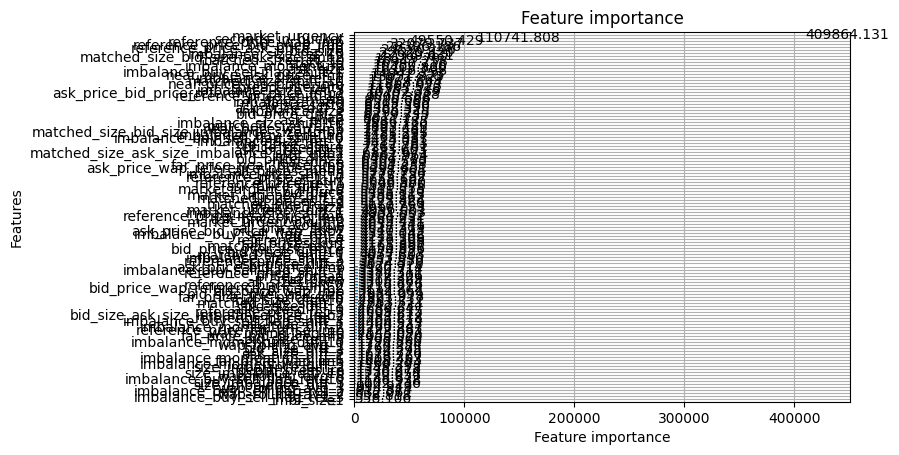

In [14]:
lgbm.plot_importance(lgbm_model, importance_type="gain")

# 6. Submission

In [15]:
import optiver2023
env = optiver2023.make_env()
iter_test = env.iter_test()

In [16]:
#print(feature_cols(test_features).columns)
#print(x_train.columns)

In [17]:
counter = 0
for (test, revealed_targets, sample_prediction) in iter_test:
    test_features = pre_process1(feature_cols(test))
    predictions = lgbm_model.predict(test_features)
    sample_prediction['target'] = predictions
    env.predict(sample_prediction)
    counter += 1

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.


/tmp/ipykernel_20/3776890319.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['imbalance_ratio'] = df['imbalance_size'] / df['matched_size']
/tmp/ipykernel_20/3776890319.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['imbl_size1'] = (df['bid_size']-df['ask_size']) / (df['bid_size']+df['ask_size'])
/opt/conda/lib/python3.10/site-packages/numba/core/ir_utils.py:2149: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for

In [18]:
#print(sample_prediction)